**Group names:** Michael Jakober, Cyril Winkler, Jaron Matzinger, Maurice Salzmann

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

Using the rent prices from appartments in Lausanne from PW 02, restricting to the feature living area.

1. Load data and normalise them - as already implemented in the notebook.
2. Reproduce the closed-form solution (of the normal equations) from PW01 (based on pytorch tensors).
3. Implement (full batch) GD for linear regression - by using pytorch tensors. Don't use automatic differentiation, but implement the formulas for the gradient explicitly. Make sure that the your GD descent algorithm works correctly by checking that the solution gradually approaches the correct solution as computed in the first step (within numerical precision). Plot estimated MSE cost vs the number of epochs with matplotlib ("loss curve").
4. Play with different learning rates. Compare the trainings on the basis of the associated loss curves. Describe what you see and interpret what is going on. What is the maximal learning rate that you can use? What happens when choosing a larger learning rate?    
5. Solve the linear regression problem by using pytorch's autograd functionality.     

### 1. Load Data and Normalize

In [2]:
import pandas as pd
df = pd.read_csv("./data/lausanne-appart.csv")
N  = df.shape[0]
df.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


In [3]:
x0 = df.values[:,0]
x = (x0-np.mean(x0))/np.std(x0)
y0 = df.values[:,2]
y = (y0-np.mean(y0))/np.std(y0)

Text(0, 0.5, 'rent_price')

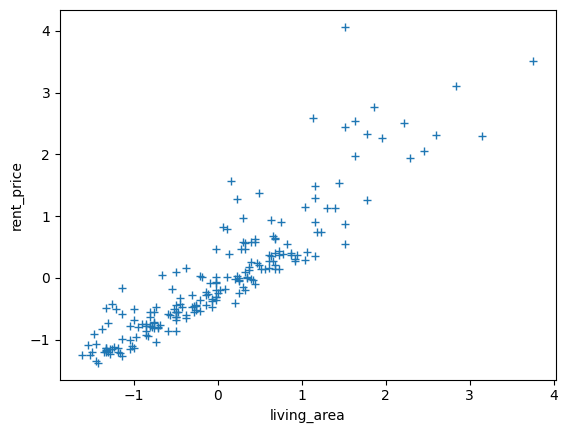

In [4]:
plt.plot(x, y,"+")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### 2. Linear Model, Normal Equations and Solution

We denote the observed rent by $y_j$ (at time $x_j$) and the model rent by $\hat{y}_j$ we assume 

$\qquad \hat{y}_j = \alpha + \beta x_j$

By minimizing the mean squares error

$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

we can fit the straigth line as follows by using the design matrix $X$ and the data vector $Y$, defined by 

$\qquad X = \left(\begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_{N-1}\end{array}\right), \qquad Y = \left(\begin{array}{c} y_0\\ \vdots \\ y_{N-1}\end{array}\right)$

We find 

$\qquad \left(\begin{array}{c}\alpha \\ \beta\end{array}\right) = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y$

Hence, here we can easily compute the (linear) model which best fits the training data in the sense of obtaining a minimal mean square error. 

#### Solution of Normal Equations in Pytorch

tensor([-1.5135e-16,  9.0425e-01], dtype=torch.float64)


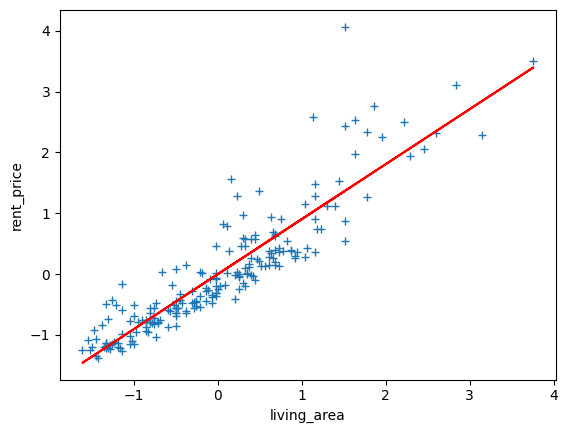

In [5]:
N = x.size

# YOUR CODE (START)
# compose torch tensors X,Y of shape (N,2) and (N,1) respectively
x_t = torch.tensor(x)
X = torch.column_stack((torch.ones_like(x_t), x_t))
Y = torch.tensor(y)

# solution of normal equations, 'a' a torch tensor of shape (2,1) that contains parameters alpha and beta, which shall be optimized
a_exact = torch.inverse(X.T @ X) @ X.T @ Y

# prediction
Yhat = X @ a_exact

# YOUR CODE (END)

# plot
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")
print(a_exact)

Note that with the pytorch function `torch.lstsq` you can obtain the same.

In [6]:
torch.linalg.lstsq(X, Y)

torch.return_types.linalg_lstsq(
solution=tensor([-1.4972e-16,  9.0425e-01], dtype=torch.float64),
residuals=tensor([], dtype=torch.float64),
rank=tensor(2),
singular_values=tensor([], dtype=torch.float64))

#### Cost

In [7]:
def cost(X,Y,a):
    # YOUR CODE (START)
    return 1/(2*N) * torch.sum((X @ a - Y)**2)
    # YOUR CODE (END)

In [8]:
min_cost = cost(X,Y,a_exact)
print(min_cost)

tensor(0.0912, dtype=torch.float64)


### 3. Gradient Descent

Specify the gradient of the cost (w.r.t. $\alpha, \beta$) here as maths expression.

In [9]:
def gradient_cost(X,Y,a):
    # YOUR CODE (START)
    y_hat = X @ a
    return X.T @ (y_hat - Y) / N
    # YOUR CODE (END)

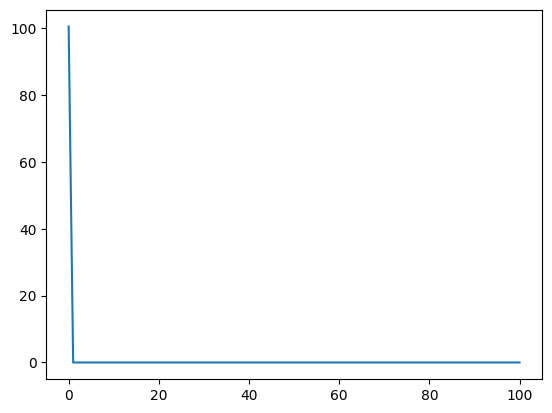

In [15]:
# adjust if needed
nepochs = 100
lr = 1

## initial parameter
a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)

# track the costs
costs = []

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    costs.append(cost(X,Y,a))
    a = a - lr * gradient_cost(X,Y,a)

costs.append(cost(X,Y,a))
    
# YOUR CODE (END)
    
# some output
cost_gd = costs[-1]
plt.plot(range(nepochs+1),costs)
#plt.plot(range(nepochs+1),cost_closed_form*torch.ones(nepochs+1))

### 4. Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

lr = 1 is the most efficient learning rate for this kind of problem, as it goes directly to the optimum.
lr = 1.999, it just works.
lr >= 2 does not work anymore

### 5. Use PyTorch's autograd

In [11]:
import torch.optim as optim

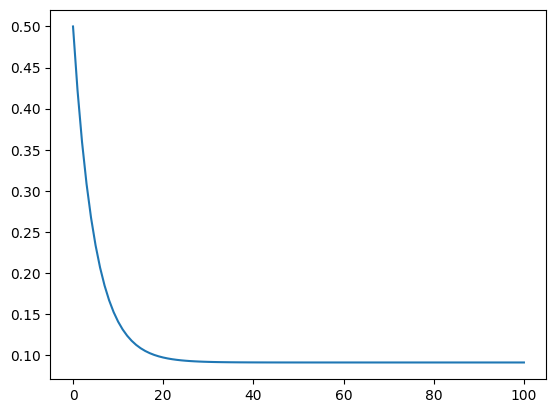

In [27]:
# adjust if needed
nepochs = 100
lr = 0.1

## initial parameter
a = torch.tensor([0.0,0.0], requires_grad=True, dtype=torch.float64)

# track the costs
costs = []

# YOUR CODE (START)

optimizer = optim.SGD([a], lr=lr)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    optimizer.zero_grad()
    loss = cost(X,Y,a)
    loss.backward()
    costs.append(loss)
    optimizer.step()
    
costs.append(cost(X,Y,a))
    
# YOUR CODE (END)
    
# some output
costs = [tensor.detach().numpy() for tensor in costs]
plt.plot(range(nepochs+1),costs)